# Import our libraries 

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
import seaborn as sns
import os
import numpy as np
import datetime as dt

# Reading Files

In [2]:

df = pd.read_csv("../input/car-crashes-severity-prediction/train.csv")
weather = pd.read_csv("../input/car-crashes-severity-prediction/weather-sfcsv.csv")
test = pd.read_csv('../input/car-crashes-severity-prediction/test.csv')
print("The shape of the dataset is {}.\n\n".format(df.shape))


The shape of the dataset is (6407, 16).




# Reading Holiday file

In [3]:
import xml.etree.ElementTree as ET
root = ET.parse("../input/car-crashes-severity-prediction/holidays.xml").getroot()

tags = {"tags":[]}
for elem in root:
    tag = {}
    tag["date"] = elem[0].text
    
    tag["description"] = elem[1].text
    #tag['description']=1
    tags["tags"].append(tag)

holidays = pd.DataFrame(tags["tags"])
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         90 non-null     object
 1   description  90 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


# Convert type of timestamp Column

In [4]:
#Convert object to date time
df['timestamp']=pd.to_datetime(df['timestamp'])

#Create date column in df dataframe 
df['date'] = [d.date() for d in df['timestamp']]
df['date']=pd.to_datetime(df['date'])

#Create date column in weather dataframe
weather["date"]= weather["Year"].astype(str)+"-" + weather["Month"].astype(str)+"-"+weather["Day"].astype(str)
weather['date'] = pd.to_datetime(weather['date'])
weather=weather.drop_duplicates(subset=['Hour', 'date'])

weather_cp = weather.copy()
df_cp = df.copy()
#========================================
df_cp["year"]=df_cp.date.dt.year
df_cp["month"]=df_cp.date.dt.month
df_cp["Day"]=df_cp.date.dt.day
df_cp['weekday'] = df_cp[['date']].apply(lambda x: dt.datetime.strftime(x['date'], '%A'), axis=1)

def hr_func(ts):
    return ts.hour
df_cp['Hour'] = df_cp['timestamp'].apply(hr_func)

#========================================
holidays_cp = holidays.copy()
holidays_cp['date']=  pd.to_datetime(holidays_cp['date'])


# Merge weather and holidays data with main dataframe

In [5]:
df_cp1 = pd.merge(df_cp,weather_cp,on=['date','Hour'],how = "left")
df_cp2 = pd.merge(df_cp1,holidays_cp,on=['date'],how = "left")


In [6]:
df_cp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6407 entries, 0 to 6406
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 6407 non-null   int64         
 1   Lat                6407 non-null   float64       
 2   Lng                6407 non-null   float64       
 3   Bump               6407 non-null   bool          
 4   Distance(mi)       6407 non-null   float64       
 5   Crossing           6407 non-null   bool          
 6   Give_Way           6407 non-null   bool          
 7   Junction           6407 non-null   bool          
 8   No_Exit            6407 non-null   bool          
 9   Railway            6407 non-null   bool          
 10  Roundabout         6407 non-null   bool          
 11  Stop               6407 non-null   bool          
 12  Amenity            6407 non-null   bool          
 13  Side               6407 non-null   object        
 14  Severity

# Drop dummy column

we will drop ID column later now we noticed that 1- Wind_Chill(F) have lots of nulls (3138).** 2- Bump** all of its data is just false. 3- Give_Way also is just all false except 3 data sets. 4- All other dummy column also as "No_Exit","Roundabout",..etc

In [7]:
cleand_df_cp = df_cp2.drop(["Junction","Year","Month","Day_y","date","ID","Wind_Chill(F)","Bump","Give_Way","No_Exit","Roundabout","timestamp"],axis=1)
cleand_df_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6407 entries, 0 to 6406
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lat                6407 non-null   float64
 1   Lng                6407 non-null   float64
 2   Distance(mi)       6407 non-null   float64
 3   Crossing           6407 non-null   bool   
 4   Railway            6407 non-null   bool   
 5   Stop               6407 non-null   bool   
 6   Amenity            6407 non-null   bool   
 7   Side               6407 non-null   object 
 8   Severity           6407 non-null   int64  
 9   year               6407 non-null   int64  
 10  month              6407 non-null   int64  
 11  Day_x              6407 non-null   int64  
 12  weekday            6407 non-null   object 
 13  Hour               6407 non-null   int64  
 14  Weather_Condition  6406 non-null   object 
 15  Precipitation(in)  3529 non-null   float64
 16  Temperature(F)     6405 

# Take a look about null data

In [8]:
cleand_df_cp.isnull().sum().sort_values(ascending = False).head(10)

description          6259
Precipitation(in)    2878
Wind_Speed(mph)       296
Humidity(%)             2
Temperature(F)          2
Visibility(mi)          1
Weather_Condition       1
Lng                     0
Selected                0
Hour                    0
dtype: int64

# Replace null with suitable values

In [9]:
cleand_df_cp['Temperature(F)']= cleand_df_cp['Temperature(F)'].fillna(cleand_df_cp['Temperature(F)'].mean())
cleand_df_cp['Visibility(mi)']= cleand_df_cp['Visibility(mi)'].fillna(cleand_df_cp['Visibility(mi)'].mean())
cleand_df_cp['Humidity(%)']= cleand_df_cp['Humidity(%)'].fillna(cleand_df_cp['Humidity(%)'].mean())
cleand_df_cp['Weather_Condition']= cleand_df_cp['Weather_Condition'].fillna("Plarty Cloudy")
cleand_df_cp['Wind_Speed(mph)']= cleand_df_cp['Wind_Speed(mph)'].fillna(cleand_df_cp['Wind_Speed(mph)'].mean())
cleand_df_cp['Precipitation(in)']= cleand_df_cp['Precipitation(in)'].fillna(cleand_df_cp['Precipitation(in)'].mean())
cleand_df_cp['description']= cleand_df_cp['description'].fillna(0)
cleand_df_cp.isnull().sum().sort_values(ascending = False).head(5)
cleand_df_cp["H_day"] = cleand_df_cp["description"].copy()

# There is no missing values now!

In [10]:
cleand_df_cp.isnull().sum().sort_values(ascending = False).head(10)

Lat                  0
weekday              0
description          0
Selected             0
Visibility(mi)       0
Wind_Speed(mph)      0
Humidity(%)          0
Temperature(F)       0
Precipitation(in)    0
Weather_Condition    0
dtype: int64

# Convert boolen datatype to 1 and 0

In [11]:
cleand_df_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6407 entries, 0 to 6406
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lat                6407 non-null   float64
 1   Lng                6407 non-null   float64
 2   Distance(mi)       6407 non-null   float64
 3   Crossing           6407 non-null   bool   
 4   Railway            6407 non-null   bool   
 5   Stop               6407 non-null   bool   
 6   Amenity            6407 non-null   bool   
 7   Side               6407 non-null   object 
 8   Severity           6407 non-null   int64  
 9   year               6407 non-null   int64  
 10  month              6407 non-null   int64  
 11  Day_x              6407 non-null   int64  
 12  weekday            6407 non-null   object 
 13  Hour               6407 non-null   int64  
 14  Weather_Condition  6407 non-null   object 
 15  Precipitation(in)  6407 non-null   float64
 16  Temperature(F)     6407 

In [12]:
bool_df1 = cleand_df_cp.select_dtypes(include = "bool")
# bool_df1.columns

for i in range(len(cleand_df_cp["description"])):
    if cleand_df_cp["description"][i] != 0:
        cleand_df_cp["H_day"][i]= 1
        

for i in range(len(cleand_df_cp['weekday'])):
    if cleand_df_cp['weekday'][i] == 'Sunday':
        cleand_df_cp['H_day'][i] = 1
    elif cleand_df_cp['weekday'][i] == 'Saturday':
        cleand_df_cp['H_day'][i] = 1
    else:
        cleand_df_cp['H_day'][i] = 0

for i in range(len(cleand_df_cp["Hour"])):
    if (cleand_df_cp["Hour"][i] > 18) or (cleand_df_cp["Hour"][i] <= 6):
        cleand_df_cp["Hour"][i]= 1
    else :
        cleand_df_cp["Hour"][i]= 0
        



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/

# Plotting

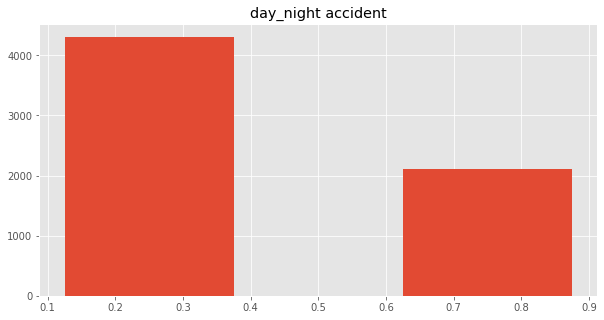

In [13]:
cleand_df_cp['Hour'].hist(bins =2 , rwidth = 0.5 ,figsize=(10,5) )
plt.title("day_night accident")
plt.show()

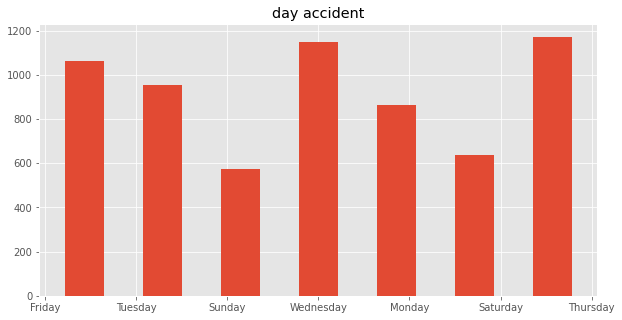

In [14]:
cleand_df_cp['weekday'].hist(bins =7 , rwidth = 0.5 ,figsize=(10,5) )
plt.title("day accident")
plt.show()

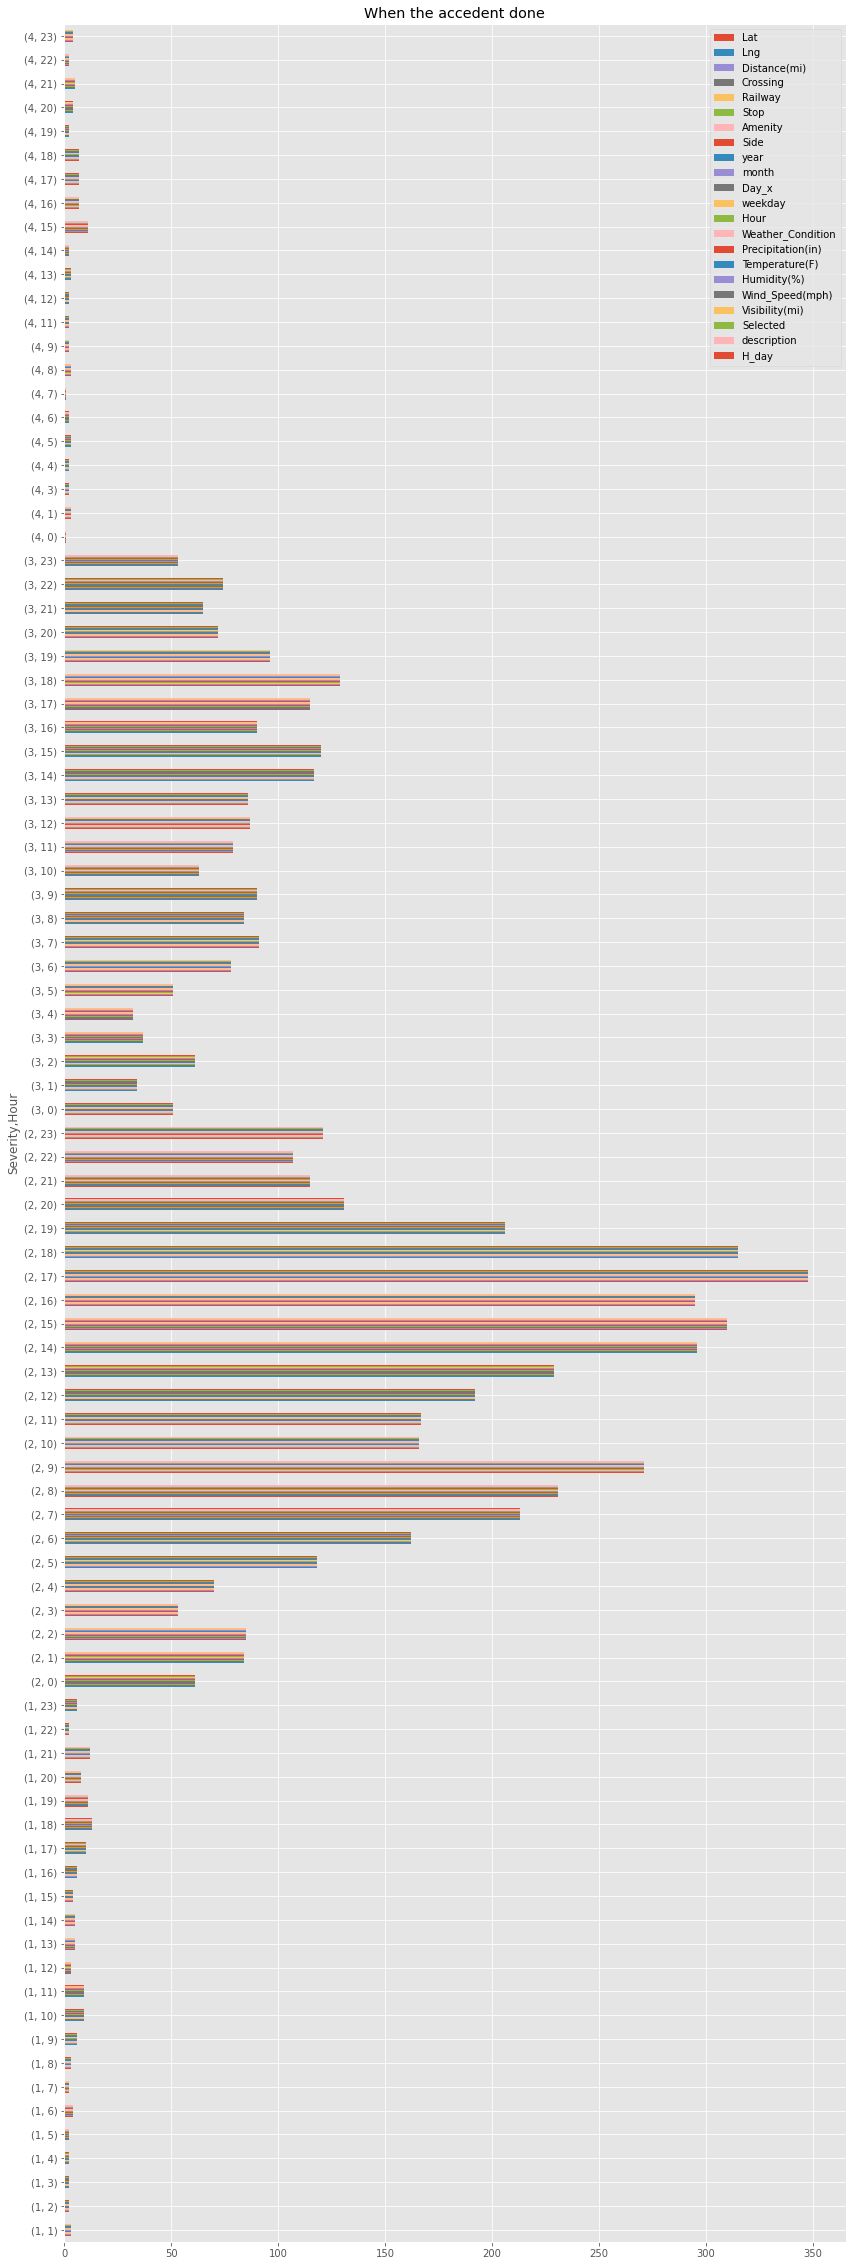

In [15]:

cleand_df_cp.groupby(['Severity',df_cp['Hour']]).count().plot(kind='barh', figsize=(14,40.8))
plt.title('When the accedent done')
plt.show()

# Encoding categorical datatype to numerical datatype

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in bool_df1.columns :
    cleand_df_cp[i]=le.fit_transform(cleand_df_cp[i])
    
cleand_df_cp["Selected"]=le.fit_transform(cleand_df_cp["Selected"])
cleand_df_cp["Weather_Condition"]=le.fit_transform(cleand_df_cp["Weather_Condition"])
cleand_df_cp["Side"]=le.fit_transform(cleand_df_cp["Side"])

cleand_df_cp = cleand_df_cp.drop(["description","weekday","Day_x","year","Precipitation(in)","Humidity(%)"],axis=1)

In [17]:
cleand_df_cp

,Lat,Lng,Distance(mi),Crossing,Railway,Stop,Amenity,Side,Severity,month,Hour,Weather_Condition,Temperature(F),Wind_Speed(mph),Visibility(mi),Selected,H_day
0,37.762150,-122.405660,0.044,0,0,0,1,1,2,3,0,23,64.0,23.0,10.0,0,0
1,37.719157,-122.448254,0.000,0,0,0,0,1,2,5,1,15,57.0,22.0,10.0,0,0
2,37.808498,-122.366852,0.000,0,0,1,0,1,3,9,1,0,62.1,9.2,10.0,0,0
3,37.785930,-122.391080,0.009,0,0,0,0,1,1,3,1,3,58.0,10.0,10.0,0,1
4,37.719141,-122.448457,0.000,0,0,0,0,1,2,10,0,3,58.0,3.0,10.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,37.740630,-122.407930,0.368,0,0,0,0,1,3,10,0,23,61.0,17.3,10.0,0,1
6403,37.752755,-122.402790,0.639,0,0,0,0,1,2,10,0,14,57.0,6.9,10.0,0,0
6404,37.726304,-122.446015,0.000,0,0,0,0,1,2,10,0,3,71.0,9.0,10.0,0,0
6405,37.808090,-122.367211,0.000,0,0,0,0,1,3,5,0,3,63.0,13.0,10.0,0,1


## Import the libraries

We'll use `pandas` to load and manipulate the data. Other libraries will be imported in the relevant sections.

In [18]:
import pandas as pd
import os

## Data Splitting

Now it's time to split the dataset for the training step. Typically the dataset is split into 3 subsets, namely, the training, validation and test sets. In our case, the test set is already predefined. So we'll split the "training" set into training and validation sets with 0.8:0.2 ratio. 

*Note: a good way to generate reproducible results is to set the seed to the algorithms that depends on randomization. This is done with the argument `random_state` in the following command* 

In [19]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(cleand_df_cp, test_size=0.2, random_state=42) # Try adding `stratify` here

X_train = train_df.drop(columns=['Severity'])
y_train = train_df['Severity']

X_val = val_df.drop(columns=['Severity'])
y_val = val_df['Severity']


As pointed out eariler, I'll use the numerical features to train the classifier. **However, you shouldn't use the numerical features only to make the final submission if you want to make it to the top of the leaderboard.** 

## Model Training

Let's train a model with the data! We'll train a Random Forest Classifier to demonstrate the process of making submissions. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier = classifier.fit(X_train, y_train)

Now let's test our classifier on the validation dataset and see the accuracy.

In [21]:
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.749609984399376


Well. That's a good start, right? A classifier that predicts all examples' `Severity` as 2 will get around 0.63. You should get better score as you add more features and do better data preprocessing.

## Submission File Generation

We have built a model and we'd like to submit our predictions on the test set! In order to do that, we'll load the test set, predict the class and save the submission file. 

First, we'll load the data.

# Convert type of timestamp Column

In [22]:
import datetime as dt
#Convert object to date time
test['timestamp']=pd.to_datetime(test['timestamp'])

#Create date column in df dataframe 
test['date'] = [d.date() for d in test['timestamp']]
test['date']=pd.to_datetime(test['date'])

weather_ts = weather.copy()


test["year"]=test.date.dt.year
test["month"]=test.date.dt.month
test["Day"]=test.date.dt.day
test['weekday'] = test[['date']].apply(lambda x: dt.datetime.strftime(x['date'], '%A'), axis=1)


def hr_func(ts):
    return ts.hour

test['Hour'] = test['timestamp'].apply(hr_func)

#========================================
holidays_ts = holidays.copy()
holidays_ts['date']=  pd.to_datetime(holidays_ts['date'])

# Merge weather and holidays data with main dataframe

In [23]:
test1 = pd.merge(test,weather_ts,on=['date','Hour'],how = "left")
test2 = pd.merge(test1,holidays_ts,on=['date'],how = "left")

# Drop dummy column

In [24]:
test2_cp = test2.drop(["Junction","Year","Month","Day_y","date","ID","Wind_Chill(F)","Bump","Give_Way","No_Exit","Roundabout","timestamp"],axis=1)


# Take a look on null data

In [25]:
test2_cp.isnull().sum().sort_values(ascending = False).head(10)

description          1564
Precipitation(in)     720
Wind_Speed(mph)        73
weekday                 0
Selected                0
Visibility(mi)          0
Humidity(%)             0
Temperature(F)          0
Weather_Condition       0
Hour                    0
dtype: int64

# Replace null with suitable values

In [26]:
test2_cp['Temperature(F)']= test2_cp['Temperature(F)'].fillna(test2_cp['Temperature(F)'].mean())
test2_cp['Visibility(mi)']= test2_cp['Visibility(mi)'].fillna(test2_cp['Visibility(mi)'].mean())
test2_cp['Humidity(%)']= test2_cp['Humidity(%)'].fillna(test2_cp['Humidity(%)'].mean())
test2_cp['Weather_Condition']= test2_cp['Weather_Condition'].fillna("Plarty Cloudy")
test2_cp['Wind_Speed(mph)']= test2_cp['Wind_Speed(mph)'].fillna(test2_cp['Wind_Speed(mph)'].mean())
test2_cp['Precipitation(in)']= test2_cp['Precipitation(in)'].fillna(test2_cp['Precipitation(in)'].mean())
test2_cp['description']= test2_cp['description'].fillna(0)
test2_cp.isnull().sum().sort_values(ascending = False).head(5)
test2_cp["H_day"] = test2_cp["description"].copy()

# Convert boolen datatype to 1 and 0

In [27]:
bool_d = test2_cp.select_dtypes(include = "bool")


for i in range(len(test2_cp["description"])):
    if test2_cp["description"][i] != 0:
        test2_cp["H_day"][i]= 1
        

for i in range(len(test2_cp['weekday'])):
    if test2_cp['weekday'][i] == 'Sunday':
        test2_cp['H_day'][i] = 1
    elif test2_cp['weekday'][i] == 'Saturday':
        test2_cp['H_day'][i] = 1
    else:
        test2_cp['H_day'][i] = 0

for i in range(len(test2_cp["Hour"])):
    if (test2_cp["Hour"][i] > 18) or (test2_cp["Hour"][i] <= 6):
        test2_cp["Hour"][i]= 1
    else :
        test2_cp["Hour"][i]= 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_la

# Encoding categorical datatype to numerical datatype

In [28]:
        
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in bool_d.columns :
    test2_cp[i]=le.fit_transform(test2_cp[i])
    
test2_cp["Selected"]=le.fit_transform(test2_cp["Selected"])
test2_cp["Weather_Condition"]=le.fit_transform(test2_cp["Weather_Condition"])
test2_cp["Side"]=le.fit_transform(test2_cp["Side"])

test2_cp = test2_cp.drop(["description","weekday","Day_x","year","Precipitation(in)","Humidity(%)"],axis=1)

Note that the test set has the same features and doesn't have the `Severity` column.
At this stage one must **NOT** forget to apply the same processing done on the training set on the features of the test set.

Now we'll add `Severity` column to the test `DataFrame` and add the values of the predicted class to it.

**I'll select the numerical features here as I did in the training set. DO NOT forget to change this step as you change the preprocessing of the training data.**

In [29]:
X_test = test2_cp

y_test_predicted = classifier.predict(X_test)

test2_cp['Severity'] = y_test_predicted

test2_cp.head()

,Lat,Lng,Distance(mi),Crossing,Railway,Stop,Amenity,Side,month,Hour,Weather_Condition,Temperature(F),Wind_Speed(mph),Visibility(mi),Selected,H_day,Severity
0,37.786060,-122.390900,0.039,0,0,0,0,1,4,1,14,63.0,10.4,10.0,0,0,2
1,37.769609,-122.415057,0.202,0,0,0,0,1,10,0,3,65.0,5.0,9.0,0,0,2
2,37.807495,-122.476021,0.000,0,0,0,0,1,9,0,11,58.0,18.0,10.0,0,0,2
3,37.761818,-122.405869,0.000,0,0,0,0,1,8,0,3,72.0,17.0,10.0,0,0,2
4,37.732350,-122.414100,0.670,0,0,0,0,1,10,0,18,57.0,5.8,10.0,0,0,2


Now we're ready to generate the submission file. The submission file needs the columns `ID` and `Severity` only.

In [30]:
test2_cp["ID"] = test.ID

test2_cp[['ID', 'Severity']].to_csv('/kaggle/working/submission.csv', index=False)
test2_cp


,Lat,Lng,Distance(mi),Crossing,Railway,Stop,Amenity,Side,month,Hour,Weather_Condition,Temperature(F),Wind_Speed(mph),Visibility(mi),Selected,H_day,Severity,ID
0,37.786060,-122.390900,0.039,0,0,0,0,1,4,1,14,63.0,10.400000,10.0,0,0,2,6407
1,37.769609,-122.415057,0.202,0,0,0,0,1,10,0,3,65.0,5.000000,9.0,0,0,2,6408
2,37.807495,-122.476021,0.000,0,0,0,0,1,9,0,11,58.0,18.000000,10.0,0,0,2,6409
3,37.761818,-122.405869,0.000,0,0,0,0,1,8,0,3,72.0,17.000000,10.0,0,0,2,6410
4,37.732350,-122.414100,0.670,0,0,0,0,1,10,0,18,57.0,5.800000,10.0,0,0,2,6411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,37.812973,-122.362335,4.460,0,0,0,0,1,6,1,1,60.0,13.000000,10.0,0,0,2,8003
1597,37.761818,-122.405861,0.010,0,0,0,0,1,12,0,14,46.0,10.888351,10.0,0,1,2,8004
1598,37.732260,-122.431970,0.431,0,0,0,0,1,2,1,13,57.9,9.200000,10.0,0,0,2,8005
1599,37.786782,-122.390126,0.000,1,0,0,0,1,10,1,3,55.0,0.000000,10.0,0,0,2,8006


The remaining steps is to submit the generated file and are as follows. 

1. Press `Save Version` on the upper right corner of this notebook.
2. Write a `Version Name` of your choice and choose `Save & Run All (Commit)` then click `Save`.
3. Wait for the saved notebook to finish running the go to the saved notebook.
4. Scroll down until you see the output files then select the `submission.csv` file and click `Submit`.

Now your submission will be evaluated and your score will be updated on the leaderboard! CONGRATULATIONS!!

## Conclusion

In this notebook, we have demonstrated the essential steps that one should do in order to get "slightly" familiar with the data and the submission process. We chose not to go into details in each step to keep the welcoming notebook simple and make a room for improvement.

You're encourged to `Fork` the notebook, edit it, add your insights and use it to create your submission.